In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.stats import chi2

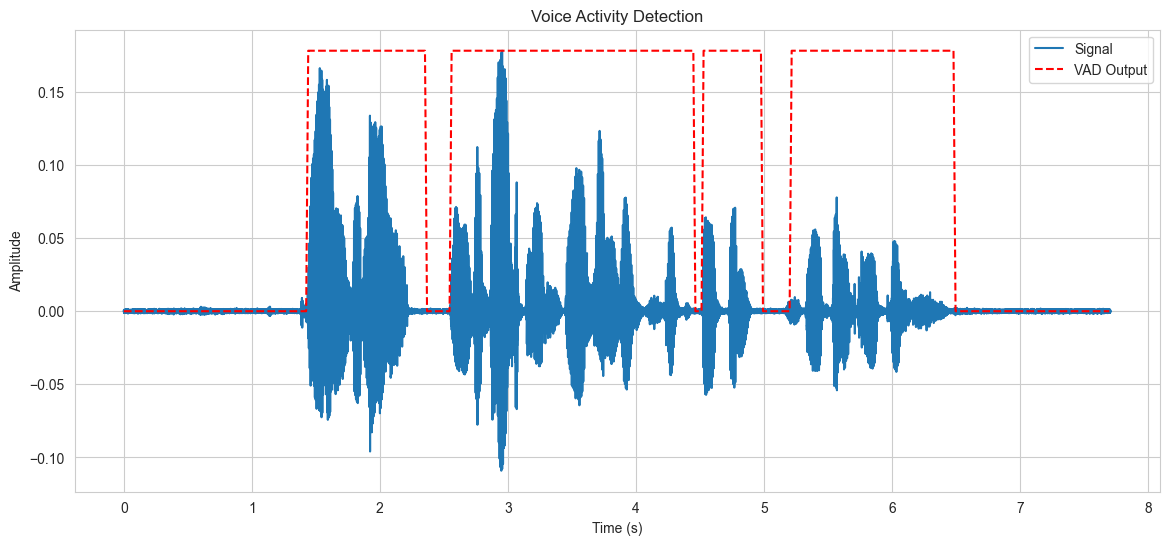

In [11]:
# Step 1: Read the audio file
def load_audio(file_path, sr=16000):
    signal, sample_rate = librosa.load(file_path, sr=sr)
    return signal, sample_rate

def add_white_noise(signal, snr_db):
    # Calculate the power of the original signal
    signal_power = np.mean(signal**2)

    # Calculate the power of the noise required for the desired SNR
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate white noise with the calculated power
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)

    # Add the noise to the signal
    noisy_signal = signal + noise
    return noisy_signal

# Step 2: Estimate noise statistics (assume initial frames are noise)
def estimate_noise(signal, frame_length=512, hop_length=256, noise_frames=5):
    stft = librosa.stft(signal, n_fft=frame_length, hop_length=hop_length)
    magnitude_spectrogram = np.abs(stft) ** 2
    noise_estimate = np.mean(magnitude_spectrogram[:, :noise_frames], axis=1)
    return noise_estimate

# Step 3: Calculate the threshold
def calculate_threshold(noise_variance, P_FA=0.1):
    # Average the noise variance to get a single threshold value
    threshold = np.sqrt(2 * noise_variance * np.log(1 / P_FA))
    return threshold

# Step 4: VAD function
def vad(signal, threshold, frame_length=512, hop_length=256, forgetting_factor = 0.8):
    stft = librosa.stft(signal, n_fft=frame_length, hop_length=hop_length)
    magnitude_spectrogram = np.abs(stft)
    n_columns = magnitude_spectrogram.shape[1]
    forgetting_factor_complement = 1 - forgetting_factor

    for i in range(1, n_columns):
        magnitude_spectrogram[:, i] = (magnitude_spectrogram[:, i] * forgetting_factor_complement + magnitude_spectrogram[:, i - 1] * forgetting_factor)

    # Calculate the test statistic by averaging over frequency bins (axis=0)
    test_statistic = np.mean(magnitude_spectrogram, axis=0)
    threshold = np.mean(threshold, axis = 0)
    # Apply the threshold to get the VAD mask
    vad_mask = test_statistic > threshold
    return vad_mask

# Step 5: Plot the results
def plot_vad(signal, vad_mask, hop_length=256, sr=16000):
    time = np.arange(len(signal)) / sr
    frame_time = np.arange(len(vad_mask)) * hop_length / sr
    plt.figure(figsize=(14, 6))
    plt.plot(time, signal, label='Signal')
    plt.plot(frame_time, vad_mask * np.max(signal), label='VAD Output', color='r', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Voice Activity Detection')
    plt.legend()
    plt.show()

# Main function to run the VAD
def main(audio_file):
    snr_db = 30
    signal, sr = load_audio(audio_file)
    signal = add_white_noise(signal, snr_db)
    noise_variance = estimate_noise(signal)
    threshold = calculate_threshold(noise_variance)
    vad_mask = vad(signal, threshold)
    plot_vad(signal, vad_mask, sr=sr)

# Usage example
audio_file = 'sample-000003.mp3'  # Replace with your audio file path
main(audio_file)


In [ ]:
# TODO: Add forgetting factor + babble noise

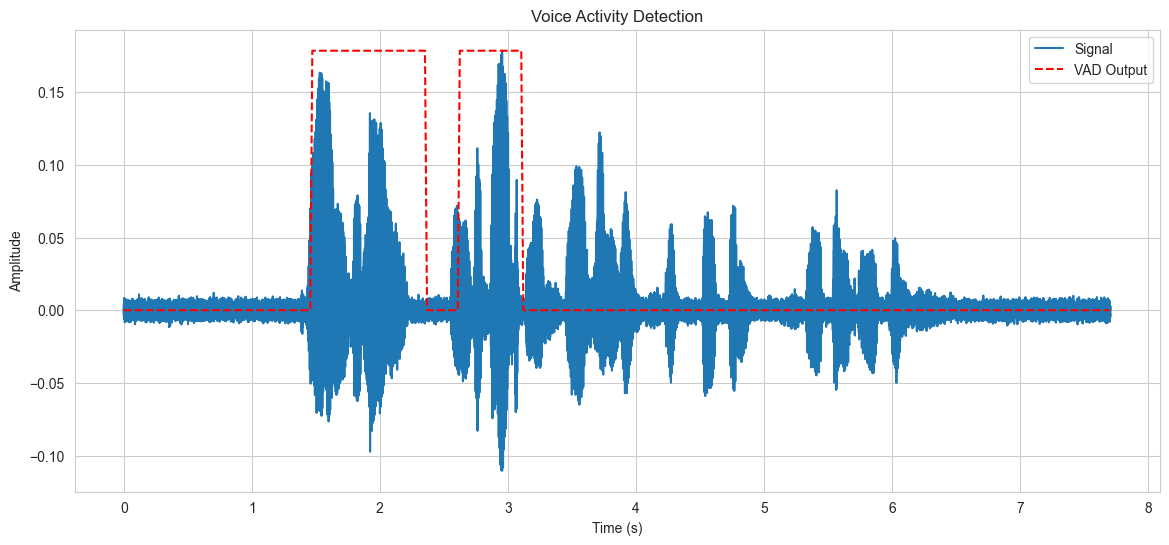

In [8]:

# Step 1: Read the audio file
def load_audio(file_path, sr=16000):
    signal, sample_rate = librosa.load(file_path, sr=sr)
    return signal, sample_rate

def add_white_noise(signal, snr_db):
    # Calculate the power of the original signal
    signal_power = np.mean(signal**2)

    # Calculate the power of the noise required for the desired SNR
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate white noise with the calculated power
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)

    # Add the noise to the signal
    noisy_signal = signal + noise
    return noisy_signal

# Step 2: Compute periodogram
def compute_periodogram(signal, frame_length, hop_length):
    stft = librosa.stft(signal, n_fft=frame_length, hop_length=hop_length, window='hann')
    periodogram = np.abs(stft) ** 2
    return periodogram

# Step 3: Recursive smoothing
def recursive_smoothing(periodogram, alpha):
    smoothed_psd = np.zeros_like(periodogram)
    smoothed_psd[:, 0] = periodogram[:, 0]
    for t in range(1, periodogram.shape[1]):
        smoothed_psd[:, t] = alpha * smoothed_psd[:, t-1] + (1 - alpha) * periodogram[:, t]
    return smoothed_psd

# Step 4: Minimum statistics
def minimum_statistics(psd, window_length):
    noise_estimate = np.zeros_like(psd)
    for f in range(psd.shape[0]):
        for t in range(psd.shape[1]):
            if t < window_length:
                noise_estimate[f, t] = np.min(psd[f, :t+1])
            else:
                noise_estimate[f, t] = np.min(psd[f, t-window_length:t+1])
    return noise_estimate

# Step 5: Noise estimation
def noise_estimation(signal, frame_length, hop_length, alpha, min_stat_window):
    periodogram = compute_periodogram(signal, frame_length, hop_length)
    smoothed_psd = recursive_smoothing(periodogram, alpha)
    noise_psd_estimate = minimum_statistics(smoothed_psd, min_stat_window)
    return noise_psd_estimate

# Step 6: Calculate the threshold
def calculate_threshold(noise_variance, P_FA=0.1):
    threshold = np.sqrt(2 * noise_variance * np.log(1 / P_FA))
    return threshold

# Step 7: VAD function
def vad(signal, threshold, frame_length=512, hop_length=256, forgetting_factor_mag=0.9, forgetting_factor_thres=0.2):
    periodogram = compute_periodogram(signal, frame_length, hop_length)
    magnitude_spectrogram = np.sqrt(periodogram)
    n_columns = magnitude_spectrogram.shape[1]
    

    for i in range(1, n_columns):
        magnitude_spectrogram[:, i] = (magnitude_spectrogram[:, i] * (1-forgetting_factor_mag) + magnitude_spectrogram[:, i - 1] * forgetting_factor_mag)
        threshold[i] = (threshold[i] * (1- forgetting_factor_thres) + threshold[i - 1] * forgetting_factor_thres)

    test_statistic = np.mean(magnitude_spectrogram, axis=0)
    #threshold = np.mean(threshold)
    vad_mask = test_statistic > threshold
    return vad_mask

# Step 8: Plot the results
def plot_vad(signal, vad_mask, hop_length=256, sr=16000):
    time = np.arange(len(signal)) / sr
    frame_time = np.arange(len(vad_mask)) * hop_length / sr
    plt.figure(figsize=(14, 6))
    plt.plot(time, signal, label='Signal')
    plt.plot(frame_time, vad_mask * np.max(signal), label='VAD Output', color='r', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Voice Activity Detection')
    plt.legend()
    plt.show()

# Main function to run the VAD
def main(audio_file):
    snr_db = 15
    frame_length = 512
    hop_length = 256
    alpha = 0.85
    min_stat_window = 96

    signal, sr = load_audio(audio_file)
    signal = add_white_noise(signal, snr_db)
    noise_psd_estimate = noise_estimation(signal, frame_length, hop_length, alpha, min_stat_window)
    noise_variance = np.mean(noise_psd_estimate, axis=0)
    threshold = calculate_threshold(noise_variance)
    vad_mask = vad(signal, threshold, frame_length, hop_length)
    plot_vad(signal, vad_mask, hop_length, sr=sr)

# Usage example
audio_file = 'sample-000003.mp3'  # Replace with your audio file path
main(audio_file)


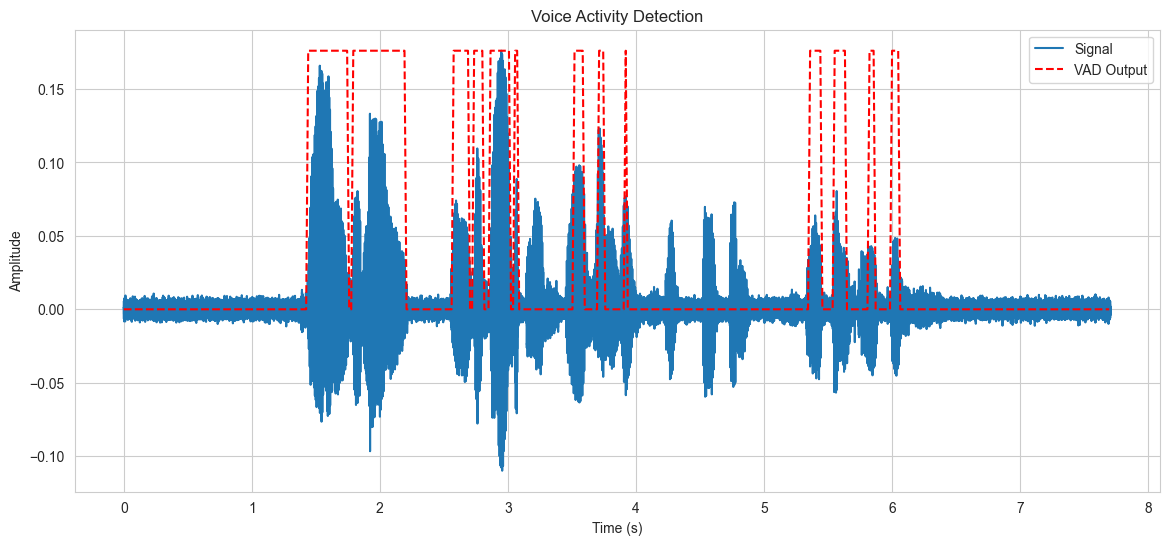

In [9]:

# Step 1: Read the audio file
def load_audio(file_path, sr=16000):
    signal, sample_rate = librosa.load(file_path, sr=sr)
    return signal, sample_rate

def add_white_noise(signal, snr_db):
    # Calculate the power of the original signal
    signal_power = np.mean(signal**2)

    # Calculate the power of the noise required for the desired SNR
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generate white noise with the calculated power
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)

    # Add the noise to the signal
    noisy_signal = signal + noise
    return noisy_signal

# Step 2: Compute periodogram
def compute_periodogram(signal, frame_length, hop_length):
    stft = librosa.stft(signal, n_fft=frame_length, hop_length=hop_length, window='hann')
    periodogram = np.abs(stft) ** 2
    return periodogram

# Step 3: Recursive smoothing
def recursive_smoothing(periodogram, alpha):
    smoothed_psd = np.zeros_like(periodogram)
    smoothed_psd[:, 0] = periodogram[:, 0]
    for t in range(1, periodogram.shape[1]):
        smoothed_psd[:, t] = alpha * smoothed_psd[:, t-1] + (1 - alpha) * periodogram[:, t]
    return smoothed_psd

# Step 4: Minimum statistics
def minimum_statistics(psd, window_length):
    noise_estimate = np.zeros_like(psd)
    for f in range(psd.shape[0]):
        for t in range(psd.shape[1]):
            if t < window_length:
                noise_estimate[f, t] = np.min(psd[f, :t+1])
            else:
                noise_estimate[f, t] = np.min(psd[f, t-window_length:t+1])
    return noise_estimate

# Step 5: Noise estimation
def noise_estimation(signal, frame_length, hop_length, alpha, min_stat_window):
    periodogram = compute_periodogram(signal, frame_length, hop_length)
    smoothed_psd = recursive_smoothing(periodogram, alpha)
    noise_psd_estimate = minimum_statistics(smoothed_psd, min_stat_window)
    return noise_psd_estimate

# Step 6: Calculate the threshold
def calculate_threshold(noise_variance, P_FA=0.1):
    threshold = np.sqrt(2 * noise_variance * np.log(1 / P_FA))
    return threshold

# Step 7: VAD function
def vad(signal, threshold, frame_length=512, hop_length=256, forgetting_factor_mag=0.9, forgetting_factor_thres=0.2):
    periodogram = compute_periodogram(signal, frame_length, hop_length)
    magnitude_spectrogram = np.sqrt(periodogram)
    n_columns = magnitude_spectrogram.shape[1]


    for i in range(1, n_columns):
        magnitude_spectrogram[:, i] = (magnitude_spectrogram[:, i] * (1-forgetting_factor_mag) + magnitude_spectrogram[:, i - 1] * forgetting_factor_mag)
        threshold[i] = (threshold[i] * (1- forgetting_factor_thres) + threshold[i - 1] * forgetting_factor_thres)

    test_statistic = np.mean(magnitude_spectrogram, axis=0)
    #threshold = np.mean(threshold)
    vad_mask = test_statistic > threshold
    return vad_mask

# Step 8: Plot the results
def plot_vad(signal, vad_mask, hop_length=256, sr=16000):
    time = np.arange(len(signal)) / sr
    frame_time = np.arange(len(vad_mask)) * hop_length / sr
    plt.figure(figsize=(14, 6))
    plt.plot(time, signal, label='Signal')
    plt.plot(frame_time, vad_mask * np.max(signal), label='VAD Output', color='r', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Voice Activity Detection')
    plt.legend()
    plt.show()

# Main function to run the VAD
def main(audio_file):
    snr_db = 15
    frame_length = 512
    hop_length = 256
    alpha = 0.85
    min_stat_window = 96

    signal, sr = load_audio(audio_file)
    signal = add_white_noise(signal, snr_db)
    noise_psd_estimate = noise_estimation(signal, frame_length, hop_length, alpha, min_stat_window)
    noise_variance = np.mean(noise_psd_estimate, axis=0)
    threshold = calculate_threshold(noise_variance)
    vad_mask = vad(signal, threshold, frame_length, hop_length, forgetting_factor_mag=0, forgetting_factor_thres=0)
    plot_vad(signal, vad_mask, hop_length, sr=sr)

# Usage example
audio_file = 'sample-000003.mp3'  # Replace with your audio file path
main(audio_file)
